In [1]:
import numpy as np
import pandas as pd
import requests
import tempfile
import os
import pyreadstat

# ============================================================
# 0. Helper: Download any NHANES .xpt file
# ============================================================

def load_nhanes_xpt(file, year="2015"):
    """
    file: e.g. 'DEMO_I.xpt'
    year: '2015'  (for 2015–2016 cycle)
    """
    url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{file}"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0 Safari/537.36"
        )
    }
    r = requests.get(url, headers=headers)
    r.raise_for_status()

    # If server returned HTML (error), fail clearly
    if b"<html" in r.content[:200].lower():
        preview = r.content[:500].decode(errors="ignore")
        raise ValueError(f"HTML returned instead of XPT:\n{url}\n\nPreview:\n{preview}")

    # write to temp file
    with tempfile.NamedTemporaryFile(suffix=".xpt", delete=False) as tmp:
        tmp.write(r.content)
        tmp_path = tmp.name

    try:
        df, meta = pyreadstat.read_xport(tmp_path)
    finally:
        os.remove(tmp_path)

    return df


# ============================================================
# 1. Download + merge NHANES 2015–2016 person-level files
# ============================================================

nhanes_files = {
    "DEMO":      "DEMO_I.xpt",
    "HDL":       "HDL_I.xpt",
    "TCHOL":     "TCHOL_I.xpt",
    "TRIGLY":    "TRIGLY_I.xpt",
    "GLU":       "GLU_I.xpt",
    "INS":       "INS_I.xpt",
    "DPQ":       "DPQ_I.xpt",
    "SLQ":       "SLQ_I.xpt",
    "DR1TOT":    "DR1TOT_I.xpt",   # day 1 total intake
    "DR1IFF":    "DR1IFF_I.xpt",   # food items (we won't use for FPED-based rPDQS)
    "PAQ":       "PAQ_I.xpt",
    "BPX":       "BPX_I.xpt",
    "BIOPRO":    "BIOPRO_I.xpt",
    "ALB_CR":    "ALB_CR_I.xpt"
}

all_dfs = {}
for name, fname in nhanes_files.items():
    print(f"Downloading {name} ({fname})...")
    df_tmp = load_nhanes_xpt(fname, "2015")
    all_dfs[name] = df_tmp
    print(f"  Loaded {name}: {df_tmp.shape}")

# Start from DEMO as person-level base
df = all_dfs["DEMO"].copy()

# Merge all other files EXCEPT DR1IFF (we don't want item-level explosion)
for name, d in all_dfs.items():
    if name in ["DEMO", "DR1IFF"]:
        continue
    df = df.merge(d, on="SEQN", how="left")

print("\nAfter merging person-level NHANES files:", df.shape)

# ============================================================
# 2. Load FPED DR1TOT day-1 file and merge
#    You already have: fped_dr1tot_1516.sas7bdat in working dir
# ============================================================

fped, meta_fped = pyreadstat.read_sas7bdat("fped_dr1tot_1516.sas7bdat")
fped = fped.copy()

print("FPED shape:", fped.shape)
print("FPED first few columns:", list(fped.columns[:20]))

# Merge FPED (per-person food group equivalents for day 1)
df = df.merge(fped, on="SEQN", how="left")
print("After merging FPED:", df.shape)

# ============================================================
# CLEAN ALL *_x / *_y DUPLICATES ACROSS THE ENTIRE DATAFRAME
# ============================================================
df = df.copy()

all_cols = df.columns
base_vars = set()

# Identify every base variable that has *_x or *_y versions.
for c in all_cols:
    if c.endswith("_x") or c.endswith("_y"):
        base_vars.add(c[:-2])

print("Duplicate variable bases found:", base_vars)

for base in base_vars:
    col_x = base + "_x"
    col_y = base + "_y"

    # Case 1 — both exist → keep _x, drop _y, rename _x → base
    if col_x in df.columns and col_y in df.columns:
        df.drop(columns=[col_y], inplace=True)
        df.rename(columns={col_x: base}, inplace=True)

    # Case 2 — only _x exists → rename to base if base not already in df
    elif col_x in df.columns and base not in df.columns:
        df.rename(columns={col_x: base}, inplace=True)

    # Case 3 — only _y exists → rename to base if base not already in df
    elif col_y in df.columns and base not in df.columns:
        df.rename(columns={col_y: base}, inplace=True)

print("✓ All *_x / *_y duplicates cleaned.")

# Verify no duplicates remain
print("Remaining *_x / *_y columns:",
      [c for c in df.columns if c.endswith('_x') or c.endswith('_y')])

# Now safe to make master copy
df_master = df.copy()

# ------------------------------------------------------------
# FIX DUPLICATE NHANES DEMOGRAPHIC COLUMNS
# Keep the "_x" versions and drop the "_y" duplicates
# ------------------------------------------------------------

demo_vars = [
    "RIAGENDR", "RIDAGEYR", "RIDRETH3",
    "SDMVPSU", "SDMVSTRA",
    "INDFMIN2", "INDFMPIR",
    "WTDRD1", "WTDR2D", "DR1DRSTZ", "DRABF", "DRDINT", "DR1TNUMF"
]

# Step 1: rename all _x versions back to their base name
rename_map = {}
for var in demo_vars:
    old = var + "_x"
    if old in df_master.columns:
        rename_map[old] = var

df_master = df_master.rename(columns=rename_map)

# ----------------------------------------------------
# FIX DUPLICATE WEIGHT VARIABLES *INSIDE df_master*
# ----------------------------------------------------

wtsaf_cols = [c for c in df_master.columns if c.startswith("WTSAF2YR")]

print("Found WTSAF2YR variants:", wtsaf_cols)

if len(wtsaf_cols) > 1:
    # Combine into a single variable using first non-null value
    df_master["WTSAF2YR"] = df_master[wtsaf_cols].bfill(axis=1).iloc[:, 0]

    # Drop all the original variants
    df_master.drop(columns=wtsaf_cols, inplace=True)

    print("✓ Cleaned. Remaining WTSAF2YR columns:",
          [c for c in df_master.columns if "WTSAF2YR" in c])
else:
    print("No duplicates found — nothing to clean.")


# ============================================================
# 3. Feature Engineering (labs, BP, eGFR, sleep, PA, PHQ)
# ============================================================

df = df_master.copy()  # work on a fresh copy

# -----------------------------
# 3.1 Basic demographics
# -----------------------------
df["sex"] = df["RIAGENDR"]               # 1=Male, 2=Female
df["race_ethnicity"] = df["RIDRETH3"]    # consistent with Longevity v1.1
df["age"] = df["RIDAGEYR"]               # age in years
df["poverty_income_ratio"] = df["INDFMIN2"]

# -----------------------------
# 3.2 Rename biochemical variables
# -----------------------------
rename_map = {
    "LBXGLU": "fasting_glucose",
    "LBXIN": "fasting_insulin",
    "LBDHDD": "hdl_cholesterol",   # HDL_I
    "LBDHDL": "hdl_cholesterol",   # alt name (not needed here but safe)
    "LBXTC": "total_cholesterol",
    "LBXTR": "triglycerides",
    "LBXSCR": "serum_creatinine"
}

df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns},
          inplace=True)

# -----------------------------
# 3.3 LDL (Friedewald) + ApoB est
# -----------------------------
def friedewald_ldl(row):
    tg = row["triglycerides"]
    if pd.isna(tg) or tg >= 400:
        return np.nan
    return row["total_cholesterol"] - row["hdl_cholesterol"] - tg / 5

if {"total_cholesterol", "hdl_cholesterol", "triglycerides"}.issubset(df.columns):
    df["ldl_cholesterol"] = df.apply(friedewald_ldl, axis=1)
    df["apob_est"] = 0.65 * df["ldl_cholesterol"] + 0.1 * df["triglycerides"]
else:
    df["ldl_cholesterol"] = np.nan
    df["apob_est"] = np.nan

# -----------------------------
# 3.4 HOMA-IR
# -----------------------------
if {"fasting_glucose", "fasting_insulin"}.issubset(df.columns):
    df["homa_ir"] = (df["fasting_insulin"] * df["fasting_glucose"]) / 405
else:
    df["homa_ir"] = np.nan

# -----------------------------
# 3.5 Blood pressure aggregates
# -----------------------------
sbp_cols = [c for c in df.columns if c.startswith("BPXSY")]
dbp_cols = [c for c in df.columns if c.startswith("BPXDI")]

if sbp_cols:
    df["sbp"] = df[sbp_cols].mean(axis=1)
if dbp_cols:
    df["dbp"] = df[dbp_cols].mean(axis=1)

if {"sbp", "dbp"}.issubset(df.columns):
    df["pulse_pressure"] = df["sbp"] - df["dbp"]
else:
    df["pulse_pressure"] = np.nan

# -----------------------------
# 3.6 eGFR — CKD-EPI 2021 (race-free)
# -----------------------------
if {"serum_creatinine", "sex", "age"}.issubset(df.columns):
    scr = df["serum_creatinine"]
    sex = df["sex"]
    age = df["age"]

    k = np.where(sex == 2, 0.7, 0.9)
    alpha = np.where(sex == 2, -0.241, -0.302)

    min_part = np.minimum(scr / k, 1) ** alpha
    max_part = np.maximum(scr / k, 1) ** -1.2

    df["egfr"] = 142 * min_part * max_part * (0.9938 ** age)
else:
    df["egfr"] = np.nan

# -----------------------------
# 3.7 Sleep metrics (SLQ030)
# -----------------------------
if "SLQ030" in df.columns:
    df["sleep_hours"] = df["SLQ030"]

    def sleep_score(x):
        if pd.isna(x):
            return np.nan
        if 7 <= x <= 9:
            return 100
        if 6 <= x < 7 or 9 < x <= 10:
            return 80
        return 50

    df["sleep_score"] = df["sleep_hours"].apply(sleep_score)
else:
    df["sleep_hours"] = np.nan
    df["sleep_score"] = np.nan

# -----------------------------
# 3.8 Physical Activity (leisure MVPA)
# -----------------------------
if {"PAD615", "PAD630"}.issubset(df.columns):
    vig_min = df["PAD615"] * df["PAD630"]
else:
    vig_min = np.nan

if {"PAD645", "PAD660"}.issubset(df.columns):
    mod_min = df["PAD645"] * df["PAD660"]
else:
    mod_min = np.nan

if not (isinstance(vig_min, float) and isinstance(mod_min, float)):
    df["mvpa_min_week"] = vig_min * 2 + mod_min
else:
    df["mvpa_min_week"] = np.nan

# -----------------------------
# 3.9 PHQ-9 total
# -----------------------------
phq_cols = [c for c in df.columns if c.startswith("DPQ0")]
if phq_cols:
    df["phq9_total"] = df[phq_cols].sum(axis=1)
else:
    df["phq9_total"] = np.nan

# -----------------------------
# 3.10 Clean common NHANES codes
# -----------------------------
df.replace({7777: np.nan, 9999: np.nan, 99999: np.nan, 999999: np.nan},
           inplace=True)

# At this point df is your main feature-engineered table
df_features = df.copy()
print("\nFeature table shape:", df_features.shape)


# ============================================================
# 4. rPDQS-style diet score from FPED day 1
#    using DR1T_* variables in FPED_DR1TOT_1516
# ============================================================

df = df_features.copy()

# If DR1DRSTZ (recall status) exists, restrict to reliable day 1
if "DR1DRSTZ" in df.columns:
    bad_mask = df["DR1DRSTZ"] != 1
else:
    bad_mask = pd.Series(False, index=df.index)

# List of FPED variables we plan to use
fped_vars_needed = [
    "DR1T_F_CITMLB", "DR1T_F_OTHER",
    "DR1T_V_DRKGR", "DR1T_V_OTHER",
    "DR1T_V_REDOR_TOTAL", "DR1T_V_STARCHY_TOTAL", "DR1T_V_LEGUMES",
    "DR1T_G_WHOLE", "DR1T_G_REFINED",
    "DR1T_PF_MEAT", "DR1T_PF_CUREDMEAT",
    "DR1T_PF_SEAFD_HI", "DR1T_PF_SEAFD_LOW",
    "DR1T_PF_NUTSDS",
    "DR1T_D_MILK", "DR1T_D_YOGURT",
    "DR1T_A_DRINKS", "DR1T_SOLID_FATS"
]

# Guarantee these columns exist (if missing, create with NaN)
for col in fped_vars_needed:
    if col not in df.columns:
        df[col] = np.nan

# Set FPED vars to NaN when recall is unreliable
if "DR1DRSTZ" in df.columns:
    df.loc[bad_mask, fped_vars_needed] = np.nan

# --- Construct approximate rPDQS food groups (servings/day) ---
df["dark_green_veg"]        = df["DR1T_V_DRKGR"]
df["other_veg"]             = (
    df["DR1T_V_OTHER"]
    + df["DR1T_V_REDOR_TOTAL"]
    + df["DR1T_V_STARCHY_TOTAL"]
    - df["DR1T_V_LEGUMES"].fillna(0)
)
df["citrus_melons_berries"] = df["DR1T_F_CITMLB"]
df["other_fruit"]           = df["DR1T_F_OTHER"]
df["legumes"]               = df["DR1T_V_LEGUMES"]                   # could add PF_LEGUMES if present
df["whole_grains"]          = df["DR1T_G_WHOLE"]
df["nuts_seeds"]            = df["DR1T_PF_NUTSDS"]
df["low_fat_dairy"]         = df["DR1T_D_MILK"] + df["DR1T_D_YOGURT"]
df["fish"]                  = df["DR1T_PF_SEAFD_HI"] + df["DR1T_PF_SEAFD_LOW"]

df["red_meat"]              = df["DR1T_PF_MEAT"]
df["processed_meat"]        = df["DR1T_PF_CUREDMEAT"]
df["refined_grains"]        = df["DR1T_G_REFINED"]
df["ssb"]                   = df["DR1T_A_DRINKS"]
df["fried_foods"]           = df["DR1T_SOLID_FATS"]   # crude proxy

healthy_groups = [
    "dark_green_veg","other_veg","citrus_melons_berries","other_fruit",
    "legumes","whole_grains","nuts_seeds","low_fat_dairy","fish"
]
unhealthy_groups = [
    "red_meat","processed_meat","refined_grains","ssb","fried_foods"
]

servings = df[["SEQN"] + healthy_groups + unhealthy_groups].set_index("SEQN")

def pos_score(s):
    """Higher intake = better (for healthy groups)."""
    s = s.fillna(0)
    if s.nunique() <= 1 or s.notna().sum() < 5:
        # If basically no variation, just give everyone 0
        return pd.Series(0.0, index=s.index)
    ranked = s.rank(method="first")
    return pd.qcut(ranked, 5, labels=[0,1,2,3,4], duplicates="drop").astype(float)

def neg_score(s):
    """Lower intake = better (for unhealthy groups)."""
    s = s.fillna(0)
    if s.nunique() <= 1 or s.notna().sum() < 5:
        # If no variation, everyone gets middle-ish score (2) or 0; here choose 0
        return pd.Series(0.0, index=s.index)
    ranked = s.rank(method="first")
    return pd.qcut(ranked, 5, labels=[4,3,2,1,0], duplicates="drop").astype(float)

# Apply scoring
for g in healthy_groups:
    servings[g + "_score"] = pos_score(servings[g])

for g in unhealthy_groups:
    servings[g + "_score"] = neg_score(servings[g])

score_cols = [g + "_score" for g in healthy_groups + unhealthy_groups]

servings["rpdqs_total"] = servings[score_cols].sum(axis=1)

# There are 14 groups * max 4 points = 56
servings["rpdqs_normalized"] = (servings["rpdqs_total"] / 56.0) * 100

# Merge back into main df
df = df.merge(
    servings[["rpdqs_total","rpdqs_normalized"]],
    left_on="SEQN", right_index=True, how="left"
)

# This is now your fully-featured dataset
df_final = df.copy()
print("\n✓ rPDQS columns present?",
      "rpdqs_total" in df_final.columns,
      "rpdqs_normalized" in df_final.columns)
print(df_final[["SEQN","rpdqs_total","rpdqs_normalized"]].head())


# ============================================================
# 5. Longevity Score v1.1: normalize all inputs (0–100)
# ============================================================

df = df_final.copy()

# ---- BMI ----
if {"BMXWT", "BMXHT"}.issubset(df.columns):
    df["bmi"] = df["BMXWT"] / (df["BMXHT"] / 100)**2
else:
    df["bmi"] = np.nan

def normalize_positive(x, low, high):
    return ((x - low) / (high - low)) * 100

def normalize_negative(x, low, high):
    return ((high - x) / (high - low)) * 100

# VO2max & OGTT not in NHANES
df["vo2max_raw"] = np.nan
df["vo2max_norm"] = np.nan
df["ogtt_raw"] = np.nan
df["ogtt_norm"] = np.nan

# ApoB
if "apob_est" in df.columns:
    df["apob_norm"] = normalize_negative(df["apob_est"], low=40, high=120)
else:
    df["apob_norm"] = np.nan

# CRP (LBXCRP)
if "LBXCRP" in df.columns:
    df["crp_norm"] = normalize_negative(df["LBXCRP"], low=0.1, high=10)
else:
    df["crp_norm"] = np.nan

# BMI
df["bmi_norm"] = normalize_negative(df["bmi"], low=18.5, high=35)

# Smoking pack-years (very crude proxy)
if {"SMD630", "SMD641"}.issubset(df.columns):
    df["cigs_per_day"] = df["SMD630"]
    df["years_smoked"] = df["SMD641"]
    df["pack_years"] = (df["cigs_per_day"] / 20) * df["years_smoked"]
    df["pack_years_norm"] = normalize_negative(df["pack_years"], low=0, high=50)
else:
    df["pack_years_norm"] = np.nan

# MoCA not in NHANES
df["moca_norm"] = np.nan

# MVPA
if "mvpa_min_week" in df.columns:
    df["mvpa_norm"] = normalize_positive(df["mvpa_min_week"], low=0, high=300)
else:
    df["mvpa_norm"] = np.nan

# CAC / HRV not in NHANES
df["cac_norm"] = np.nan
df["hrv_norm"] = np.nan

# PHQ-9
df["phq9_norm"] = normalize_negative(df["phq9_total"], low=0, high=27)

# ALT (LBXSGPT)
if "LBXSGPT" in df.columns:
    df["alt_norm"] = normalize_negative(df["LBXSGPT"], low=8, high=50)
else:
    df["alt_norm"] = np.nan

# eGFR
if "egfr" in df.columns:
    df["egfr_norm"] = normalize_positive(df["egfr"], low=60, high=110)
else:
    df["egfr_norm"] = np.nan

# BMD, TruAge, shdl, REM, SWLS not available
df["bmd_norm"] = np.nan
df["truage_norm"] = np.nan
df["shdl_norm"] = np.nan
df["rem_norm"] = np.nan
df["swls_norm"] = np.nan

# Grip strength (if MGDC* present)
grip_vars = [c for c in df.columns if "MGDC" in c]
if grip_vars:
    df["grip_strength"] = df[grip_vars].max(axis=1)
    df["grip_norm"] = normalize_positive(df["grip_strength"], low=10, high=60)
else:
    df["grip_norm"] = np.nan

# Diet quality
df["diet_norm"] = df["rpdqs_normalized"]

# Collect Longevity Score 1.1 variables
longevity_inputs = [
    "ogtt_norm","apob_norm","vo2max_norm","crp_norm","bmi_norm",
    "pack_years_norm","moca_norm","mvpa_norm","cac_norm","hrv_norm",
    "phq9_norm","alt_norm","egfr_norm","bmd_norm","truage_norm",
    "shdl_norm","rem_norm","grip_norm","swls_norm","diet_norm"
]

df_longevity = df[["SEQN"] + longevity_inputs].copy()

print("\nLongevity variable matrix shape:", df_longevity.shape)
print(df_longevity.head())


  Loaded DEMO: (9971, 47)
  Loaded HDL: (8021, 3)
  Loaded TCHOL: (8021, 3)
  Loaded TRIGLY: (3191, 6)
  Loaded GLU: (3191, 4)
  Loaded INS: (3191, 7)
  Loaded DPQ: (5735, 11)
  Loaded SLQ: (6327, 8)
  Loaded DR1TOT: (9544, 168)
  Loaded DR1IFF: (121481, 84)
  Loaded PAQ: (9255, 94)
  Loaded BPX: (9544, 21)
  Loaded BIOPRO: (6744, 38)
  Loaded ALB_CR: (8608, 8)

After merging person-level NHANES files: (9971, 406)
FPED shape: (9544, 51)
FPED first few columns: ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'SDMVPSU', 'SDMVSTRA', 'INDFMIN2', 'INDFMPIR', 'WTDRD1', 'WTDR2D', 'DR1DRSTZ', 'DRABF', 'DRDINT', 'DR1TNUMF', 'DR1T_F_CITMLB', 'DR1T_F_OTHER', 'DR1T_F_JUICE', 'DR1T_F_TOTAL', 'DR1T_V_DRKGR', 'DR1T_V_REDOR_TOMATO']
After merging FPED: (9971, 456)
Duplicate variable bases found: {'SDMVPSU', 'WTDR2D', 'RIAGENDR', 'RIDAGEYR', 'INDFMIN2', 'RIDRETH3', 'DR1DRSTZ', 'DRDINT', 'SDMVSTRA', 'DR1TNUMF', 'WTSAF2YR', 'DRABF', 'WTDRD1', 'INDFMPIR'}
✓ All *_x / *_y duplicates cleaned.
Remaining *_x / *

In [2]:
def qc_nhanes_merge(df_master, fped):
    print("===============================================")
    print("        NHANES MERGE QUALITY CHECK (QC)")
    print("===============================================\n")

    # 1. Shape
    print("[1] Dataset shape:")
    print(f"    df_master.shape = {df_master.shape}")
    if df_master.shape[0] == 9971:
        print("    ✓ PASS — correct number of rows for 2015–2016 DEMO\n")
    else:
        print("    ✗ WARN — unexpected number of rows\n")

    # 2. SEQN uniqueness
    print("[2] Unique SEQN check:")
    is_unique = df_master["SEQN"].is_unique
    print(f"    SEQN unique? → {is_unique}")
    print("    " + ("✓ PASS\n" if is_unique else "✗ FAIL — duplicate SEQN values\n"))

    # 3. Any leftover _x/_y columns?
    print("[3] Duplicate merge columns (_x/_y):")
    dup_cols = [c for c in df_master.columns if c.endswith("_x") or c.endswith("_y")]
    print(f"    Found: {dup_cols}")
    if len(dup_cols) == 0:
        print("    ✓ PASS — all merge duplicates cleaned\n")
    else:
        print("    ✗ FAIL — some *_x / *_y columns still present\n")

    # 4. FPED variable check
    print("[4] FPED variable check:")
    # How many DR1T_* variables exist in the original FPED file?
    fped_drs = [c for c in fped.columns if c.startswith("DR1T_")]
    df_drs   = [c for c in df_master.columns if c.startswith("DR1T_")]
    print(f"    Number of DR1T_* in FPED:      {len(fped_drs)}")
    print(f"    Number of DR1T_* in df_master: {len(df_drs)}")

    if set(fped_drs).issubset(df_master.columns):
        print("    ✓ PASS — all FPED DR1T_* vars are present in df_master\n")
    else:
        missing = [c for c in fped_drs if c not in df_master.columns]
        print("    ✗ FAIL — some FPED DR1T_* vars missing from df_master:")
        print(f"        Missing: {missing}\n")

    # 5. DR1DRSTZ for SEQN 93700
    print("[5] DR1DRSTZ for SEQN 93700 (expected = 2.0):")
    val = df_master.loc[df_master["SEQN"] == 93700, "DR1DRSTZ"].tolist()
    print(f"    Value: {val}")
    if val == [2.0] or val == [2]:
        print("    ✓ PASS — correct DR1DRSTZ merge for 93700\n")
    else:
        print("    ✗ WARN — unexpected DR1DRSTZ for 93700\n")

    # 6. Check if 93700 exists in FPED
    print("[6] Check if 93700 exists in FPED:")
    exists_fped = 93700 in fped["SEQN"].values
    print(f"    Exists in FPED? → {exists_fped}")
    print("    " + ("✓ PASS — FPED contains 93700\n" if exists_fped else "✗ FAIL — 93700 not found in FPED\n"))

    print("===============================================")
    print("QC complete.")
    print("===============================================\n")


In [17]:
qc_nhanes_merge(df_master, fped)


        NHANES MERGE QUALITY CHECK (QC)

[1] Dataset shape:
    df_master.shape = (9971, 440)
    ✓ PASS — correct number of rows for 2015–2016 DEMO

[2] Unique SEQN check:
    SEQN unique? → True
    ✓ PASS

[3] Duplicate merge columns (_x/_y):
    Found: []
    ✓ PASS — all merge duplicates cleaned

[4] FPED variable check:
    Number of DR1T_* in FPED:      37
    Number of DR1T_* in df_master: 37
    ✓ PASS — all FPED DR1T_* vars are present in df_master

[5] DR1DRSTZ for SEQN 93700 (expected = 2.0):
    Value: [2.0]
    ✓ PASS — correct DR1DRSTZ merge for 93700

[6] Check if 93700 exists in FPED:
    Exists in FPED? → True
    ✓ PASS — FPED contains 93700

QC complete.



# optional code to examine full data set

In [18]:
# df_master is the authoritative merged dataset (NHANES + FPED)
# Use df_master for all QC, validation, and re-running feature engineering.
# df, df_features, df_final, df_longevity are downstream engineered variants.

#examine the FULL dataset, df_master

print("Number of columns:", df_master.shape[1])

print("\n--- FULL VARIABLE LIST ---")
for c in df_master.columns:
    print(c)

print("\n--- DATA TYPES ---")
print(df_master.dtypes)

print("\n--- VARIABLE PREFIX COUNTS ---")
from collections import Counter
prefixes = [c.split("_")[0] for c in df_master.columns]
print(Counter(prefixes).most_common())

print("\n--- FIRST 5 ROWS ---")
display(df_master.head())

print("\n--- MISSINGNESS (% missing) ---")
missing = df_master.isna().mean().sort_values(ascending=False)
print(missing)


Number of columns: 440

--- FULL VARIABLE LIST ---
SEQN
SDDSRVYR
RIDSTATR
RIAGENDR
RIDAGEYR
RIDAGEMN
RIDRETH1
RIDRETH3
RIDEXMON
RIDEXAGM
DMQMILIZ
DMQADFC
DMDBORN4
DMDCITZN
DMDYRSUS
DMDEDUC3
DMDEDUC2
DMDMARTL
RIDEXPRG
SIALANG
SIAPROXY
SIAINTRP
FIALANG
FIAPROXY
FIAINTRP
MIALANG
MIAPROXY
MIAINTRP
AIALANGA
DMDHHSIZ
DMDFMSIZ
DMDHHSZA
DMDHHSZB
DMDHHSZE
DMDHRGND
DMDHRAGE
DMDHRBR4
DMDHREDU
DMDHRMAR
DMDHSEDU
WTINT2YR
WTMEC2YR
SDMVPSU
SDMVSTRA
INDHHIN2
INDFMIN2
INDFMPIR
LBDHDD
LBDHDDSI
LBXTC
LBDTCSI
LBXTR
LBDTRSI
LBDLDL
LBDLDLSI
LBXGLU
LBDGLUSI
LBXIN
LBDINSI
LBDINLC
PHAFSTHR
PHAFSTMN
DPQ010
DPQ020
DPQ030
DPQ040
DPQ050
DPQ060
DPQ070
DPQ080
DPQ090
DPQ100
SLQ300
SLQ310
SLD012
SLQ030
SLQ040
SLQ050
SLQ120
WTDRD1
WTDR2D
DR1DRSTZ
DR1EXMER
DRABF
DRDINT
DR1DBIH
DR1DAY
DR1LANG
DR1MRESP
DR1HELP
DBQ095Z
DBD100
DRQSPREP
DR1STY
DR1SKY
DRQSDIET
DRQSDT1
DRQSDT2
DRQSDT3
DRQSDT4
DRQSDT5
DRQSDT6
DRQSDT7
DRQSDT8
DRQSDT9
DRQSDT10
DRQSDT11
DRQSDT12
DRQSDT91
DR1TNUMF
DR1TKCAL
DR1TPROT
DR1TCARB
DR1TSUGR
DR1TFIBE
DR1TTF

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DR1T_PF_LEGUMES,DR1T_PF_TOTAL,DR1T_D_MILK,DR1T_D_YOGURT,DR1T_D_CHEESE,DR1T_D_TOTAL,DR1T_OILS,DR1T_SOLID_FATS,DR1T_ADD_SUGARS,DR1T_A_DRINKS
0,83732.0,9.0,2.0,1.0,62.0,NaN,3.0,3.0,1.0,NaN,...,2.69,7.57,0.00,0.0,0.00,0.00,24.93,35.37,3.21,0.00
1,83733.0,9.0,2.0,1.0,53.0,NaN,3.0,3.0,1.0,NaN,...,0.00,5.18,0.11,0.0,0.00,0.11,4.69,57.97,40.17,6.34
2,83734.0,9.0,2.0,1.0,78.0,NaN,3.0,3.0,2.0,NaN,...,7.47,7.89,0.13,0.0,0.00,0.13,37.43,31.27,3.07,0.00
3,83735.0,9.0,2.0,2.0,56.0,NaN,3.0,3.0,2.0,NaN,...,0.00,3.33,1.66,0.0,1.17,2.83,21.12,18.58,6.64,0.00
4,83736.0,9.0,2.0,2.0,42.0,NaN,4.0,4.0,2.0,NaN,...,0.00,2.17,0.00,0.0,0.00,0.00,6.40,7.07,13.12,0.00



--- MISSINGNESS (% missing) ---
DRQSDT5     0.999799
PAQ724M     0.999699
PAQ724L     0.999599
PAQ724G     0.999499
PAQ759C     0.999499
              ...   
DMDHRGND    0.000000
SDMVPSU     0.000000
WTMEC2YR    0.000000
WTINT2YR    0.000000
SDMVSTRA    0.000000
Length: 440, dtype: float64


## ignore, this code is for the wrong mortality data set
note: it turns out that there is no publically available LMF for this year of NHANES. So this code is pointless
because the mortality data is for a totally different year's cohort (I think 2011)
I will keep the code here in inactive form as it may prove useful later. 

In [4]:
df_longevity.to_csv("nhanes_longevity_1516.csv", index=False)

In [5]:
df_final.to_csv("nhanes_full_1516.csv", index=False)

In [8]:
# this code imports the mortality LMF file into this data set 
import pandas as pd

df_nhanes = pd.read_csv("nhanes_full_1516.csv")

lmf_clean = pd.read_csv("nhanes_lmf_clean.csv")

df_merged = df_nhanes.merge(lmf_clean, on="SEQN", how="left")


In [ ]:
# note: if you want to do the import to the nhanes longevity data set
import pandas as pd

# df_nhanes = pd.read_csv("nhanes_longevity_1516.csv")

# lmf_clean = pd.read_csv("nhanes_lmf_clean.csv")

# df_merged = df_nhanes.merge(lmf_clean, on="SEQN", how="left")


In [11]:
#df_merged.head()
#df_merged.shape


(9971, 481)

In [13]:
# set up KM plots

# quick sanity checks to start
#df_merged[["death","months_followup"]].describe(include="all")


#df_merged[["mortstat","permth_exm"]].head()


,death,months_followup
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


## resume coding

In [3]:
# generate ML-ready matrix
# clean, imputed, standardized --> production-grade pipeline

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# ============================================================
# 0. Copy dataset
# ============================================================

df_ml = df_final.copy()        # <-- replace with your merged df name
df_ml = df_ml.drop_duplicates(subset=["SEQN"])

print("Initial shape:", df_ml.shape)

# ============================================================
# 1. Identify variable types
# ============================================================

id_cols = ["SEQN"]

# treat categorical vars as numeric but later one-hot if needed
categorical_like = [
    "RIAGENDR", "RIDRETH3", "DMDMARTL", "DMDEDUC2", "DMDEDUC3",
    "poverty_income_ratio"
]

# Remove obvious non-ML columns (weights, design variables)
drop_cols = [c for c in df_ml.columns if c.startswith(("WT", "SDMV"))]

df_ml = df_ml.drop(columns=drop_cols)
print("After dropping survey weights:", df_ml.shape)

# ============================================================
# 2. Keep only numeric columns for ML
# ============================================================

numeric_cols = df_ml.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in id_cols]

X = df_ml[id_cols + numeric_cols].copy()
print("Numeric matrix shape:", X.shape)

# ============================================================
# 3. Clean impossible/dummy values
# ============================================================

# Standard NHANES missing codes
missing_codes = {
    7777: np.nan, 777: np.nan, 
    9999: np.nan, 999: np.nan,
    99999: np.nan, 999999: np.nan
}

X = X.replace(missing_codes)

# Remove columns that are >95% missing (no value)
missing_fraction = X.isna().mean()
cols_to_drop = missing_fraction[missing_fraction > 0.95].index.tolist()

print(f"Dropping {len(cols_to_drop)} nearly-empty variables.")
X.drop(columns=cols_to_drop, inplace=True)

# ============================================================
# 4. Imputation — KNN if possible, else median
# ============================================================

X_impute_only = X.set_index("SEQN").copy()

try:
    imputer = KNNImputer(n_neighbors=7, weights="distance")
    X_imputed_arr = imputer.fit_transform(X_impute_only)

    X_imputed = pd.DataFrame(X_imputed_arr,
                             index=X_impute_only.index,
                             columns=X_impute_only.columns)
    print("KNN Imputation successful.")

except Exception as e:
    print("KNN failed → Falling back to median imputation:", e)
    X_imputed = X_impute_only.fillna(X_impute_only.median())

# Add back SEQN
X_imputed = X_imputed.reset_index()

# ------------------------------------------------------------
# SAVE IMPUTED MATRIX HERE
# ------------------------------------------------------------
X_imputed.to_feather("X_imputed.feather")
print("Saved imputed dataset → X_imputed.feather")

# ------------------------------------------------------------
# Continue pipeline below this
# ------------------------------------------------------------


Initial shape: (9971, 471)
After dropping survey weights: (9971, 465)
Numeric matrix shape: (9971, 463)
Dropping 98 nearly-empty variables.
KNN Imputation successful.
Saved imputed dataset → X_imputed.feather


In [4]:
# ============================================================
# 4b. REDEFINE numeric columns AFTER cleaning & imputation
# ============================================================

# Recompute numeric columns from imputed dataset
numeric_cols = [
    c for c in X_imputed.columns
    if c not in ["SEQN"]
    and pd.api.types.is_numeric_dtype(X_imputed[c])
]

print("Final numeric column count:", len(numeric_cols))

# ============================================================
# 5. Standardization (z-score)
# ============================================================

scaler = StandardScaler()

X_std_arr = scaler.fit_transform(X_imputed[numeric_cols])

X_standardized = pd.DataFrame(
    X_std_arr,
    columns=numeric_cols,
    index=X_imputed.index
)

# Add back SEQN
X_standardized.insert(0, "SEQN", X_imputed["SEQN"])

print("\n=== STANDARDIZATION COMPLETE ===")
print("X_standardized shape:", X_standardized.shape)

Final numeric column count: 364

=== STANDARDIZATION COMPLETE ===
X_standardized shape: (9971, 365)


note: all this returns 3 outputs:

X_clean — cleaned but not imputed

X_imputed — all numeric holes filled

X_standardized — fully ML-ready

## build frailty index 

In [25]:
import numpy as np
import pandas as pd

# df_ml must contain the engineered variables:
# age, BMI, fasting_glucose, hdl_cholesterol, triglycerides, ldl_cholesterol,
# egfr, sleep_score, mvpa_min_week, phq9_total, etc.

df_val = df_ml.copy()

###########################################
# Helper function for safe deficit creation
###########################################
def deficit_if(col, condition):
    """Return deficit (0/1) if col exists, else NaN."""
    if col not in df_val.columns:
        return pd.Series(np.nan, index=df_val.index)
    return condition(df_val[col]).astype(float)

###########################################
# Frailty deficit definitions
###########################################
frailty = pd.DataFrame(index=df_val.index)

# ---- Metabolic & Lipid Deficits ----
frailty["diabetes"]       = deficit_if("fasting_glucose", lambda x: x >= 126)
frailty["low_hdl"]        = deficit_if("hdl_cholesterol", lambda x: x < 40)
frailty["high_trig"]      = deficit_if("triglycerides", lambda x: x >= 150)
frailty["high_ldl"]       = deficit_if("ldl_cholesterol", lambda x: x >= 160)

# ---- Kidney Disease ----
frailty["kidney_disease"] = deficit_if("egfr", lambda x: x < 60)

# ---- BMI Deficits ----
frailty["obesity"]        = deficit_if("BMI", lambda x: x >= 30)
frailty["underweight"]    = deficit_if("BMI", lambda x: x < 18.5)

# ---- Mental Health ----
frailty["phq9_moderate"]  = deficit_if("phq9_total", lambda x: x >= 10)

# ---- Activity & Function ----
frailty["low_mvpa"]       = deficit_if("mvpa_min_week", lambda x: x < 150)

# ---- Sleep ----
frailty["poor_sleep"]     = deficit_if("sleep_score", lambda x: x < 80)

# ---- Inflammation (CRP) ----
if "LBXCRP" in df_val.columns:
    df_val["crp"] = df_val["LBXCRP"]
elif "LBDCRP" in df_val.columns:
    df_val["crp"] = df_val["LBDCRP"]
else:
    df_val["crp"] = np.nan

frailty["crp_deficit"]    = (df_val["crp"] > 3).astype(float)

###########################################
# Compute Frailty Index (FI)
###########################################
frailty["deficits_present"] = frailty.sum(axis=1)
frailty["deficits_possible"] = frailty.notna().sum(axis=1)
frailty["frailty_index"] = frailty["deficits_present"] / frailty["deficits_possible"]

# Merge FI back into dataset
df_val["frailty_index"] = frailty["frailty_index"]

print("Frailty Index completed.")
df_val[["frailty_index"]].head()


# Keep only columns that exist and have > 30 non-missing values and >1 unique value
reverse_vars = [
    v for v in reverse_vars 
    if v in df_val.columns 
    and df_val[v].notna().sum() > 30 
    and df_val[v].nunique() > 1
]

normal_vars = [
    v for v in normal_vars
    if v in df_val.columns
    and df_val[v].notna().sum() > 30
    and df_val[v].nunique() > 1
]

print("reverse_vars used:", reverse_vars)
print("normal_vars used:", normal_vars)


Frailty Index completed.
reverse_vars used: ['fasting_glucose', 'homa_ir', 'ldl_cholesterol', 'triglycerides', 'apob_est', 'phq9_total', 'egfr']
normal_vars used: ['hdl_cholesterol', 'sleep_score', 'mvpa_min_week', 'rpdqs_normalized']


## create longevity score

In [29]:
df_val = df_ml.copy()


In [30]:
# Lower = better (reverse-coded)
reverse_vars = [
    "fasting_glucose",
    "homa_ir",
    "ldl_cholesterol",
    "triglycerides",
    "apob_est",
    "phq9_total",
    # NOTE: egfr is *not* here anymore
]

# Higher = better
normal_vars = [
    "hdl_cholesterol",
    "sleep_score",
    "rpdqs_normalized",
    "egfr",       # moved here: high eGFR is good
]

In [31]:
reverse_vars = [v for v in reverse_vars if v in df_val.columns]
normal_vars  = [v for v in normal_vars  if v in df_val.columns]

print("Reverse-coded:", reverse_vars)
print("Normal:", normal_vars)


Reverse-coded: ['fasting_glucose', 'homa_ir', 'ldl_cholesterol', 'triglycerides', 'apob_est', 'phq9_total', 'egfr']
Normal: ['hdl_cholesterol', 'sleep_score', 'mvpa_min_week', 'rpdqs_normalized']


In [49]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Make sure df_val is not modified elsewhere
df_val = df_val.copy()

# ---- HIGHER = BETTER ----
scaler_normal = StandardScaler()
df_val["ls_normal"] = (
    pd.DataFrame(
        scaler_normal.fit_transform(df_val[normal_vars]),
        columns=normal_vars,
        index=df_val.index
    ).mean(axis=1)
)

# ---- LOWER = BETTER (reverse-coded) ----
scaler_reverse = StandardScaler()
df_val["ls_reverse"] = (
    pd.DataFrame(
        scaler_reverse.fit_transform(df_val[reverse_vars]),
        columns=reverse_vars,
        index=df_val.index
    ).mean(axis=1) * -1    # Reverse direction
)


In [50]:
df_val["normalized_score"] = df_val[["ls_normal", "ls_reverse"]].mean(axis=1)


In [51]:
min_s = df_val["normalized_score"].min()
max_s = df_val["normalized_score"].max()

df_val["longevity_score"] = 300 + (df_val["normalized_score"] - min_s) * (
    550 / (max_s - min_s)
)


In [52]:
"longevity_score" in df_val.columns


True

In [53]:
df_val[["ls_normal","ls_reverse","normalized_score","longevity_score"]].head()


,ls_normal,ls_reverse,normalized_score,longevity_score
0,-0.626708,0.203410,-0.211649,631.259556
1,-0.912757,-0.458724,-0.685740,585.124370
2,-0.738634,-0.277938,-0.508286,602.393004
3,1.334160,-0.940654,0.196753,671.002358
4,1.121435,-0.286757,0.417339,692.468207


## create frailty score

In [40]:
df_val = df_val.copy()

# ----------------------------
# Define deficit rules
# ----------------------------

frailty_defs = {}

# 1. Cardiometabolic
if "bmi" in df_val.columns:
    frailty_defs["obesity"] = (df_val["bmi"] >= 30).astype(int)
    frailty_defs["underweight"] = (df_val["bmi"] < 18.5).astype(int)

if "hdl_cholesterol" in df_val.columns:
    frailty_defs["low_hdl"] = (df_val["hdl_cholesterol"] < 40).astype(int)

if "ldl_cholesterol" in df_val.columns:
    frailty_defs["high_ldl"] = (df_val["ldl_cholesterol"] > 160).astype(int)

# 2. Inflammation
if "crp" in df_val.columns:
    frailty_defs["high_crp"] = (df_val["crp"] > 3).astype(int)

# 3. Metabolic
if "fasting_glucose" in df_val.columns:
    frailty_defs["prediabetes"] = (df_val["fasting_glucose"] >= 100).astype(int)

if "homa_ir" in df_val.columns:
    frailty_defs["insulin_resistance"] = (df_val["homa_ir"] > 2.0).astype(int)

# 4. Kidney function
if "egfr" in df_val.columns:
    frailty_defs["ckd"] = (df_val["egfr"] < 60).astype(int)

# 5. Mental health
if "phq9_total" in df_val.columns:
    frailty_defs["depression"] = (df_val["phq9_total"] >= 10).astype(int)

# 6. Physical activity
if "mvpa_min_week" in df_val.columns:
    frailty_defs["low_activity"] = (df_val["mvpa_min_week"] < 150).astype(int)

# Convert rules into DataFrame
frailty_df = pd.DataFrame(frailty_defs)

# Frailty index = mean of deficits (row-wise)
df_val["frailty_index"] = frailty_df.mean(axis=1)

print("Frailty index created — preview:")
df_val[["SEQN","frailty_index"]].head()


Frailty index created — preview:


,SEQN,frailty_index
0,83732.0,0.000000
1,83733.0,0.428571
2,83734.0,0.285714
3,83735.0,0.142857
4,83736.0,0.000000


In [41]:
"frailty_index" in df_val.columns


True

In [42]:
df_val["frailty_index"].describe()


count    9971.000000
mean        0.081637
std         0.131951
min         0.000000
25%         0.000000
50%         0.000000
75%         0.142857
max         0.714286
Name: frailty_index, dtype: float64

## compare longevity score and frailty index

In [54]:
val = df_val[["longevity_score", "frailty_index", "age"]].dropna()

corr = val["longevity_score"].corr(val["frailty_index"])
print("Correlation:", corr)


Correlation: -0.3203171525083063


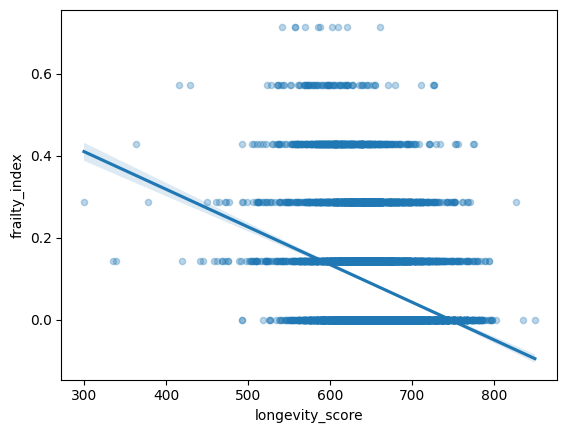

In [55]:
sns.regplot(
    data=val,
    x="longevity_score",
    y="frailty_index",
    scatter_kws={"alpha":0.3, "s":20}
)
plt.show()


In [56]:
val["LS_quartile"] = pd.qcut(val["longevity_score"], 4, labels=["Q1 Low","Q2","Q3","Q4 High"])

val.groupby("LS_quartile")["frailty_index"].mean()



/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_52709/3706306165.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val.groupby("LS_quartile")["frailty_index"].mean()


LS_quartile
Q1 Low     0.148587
Q2         0.083777
Q3         0.055091
Q4 High    0.039081
Name: frailty_index, dtype: float64

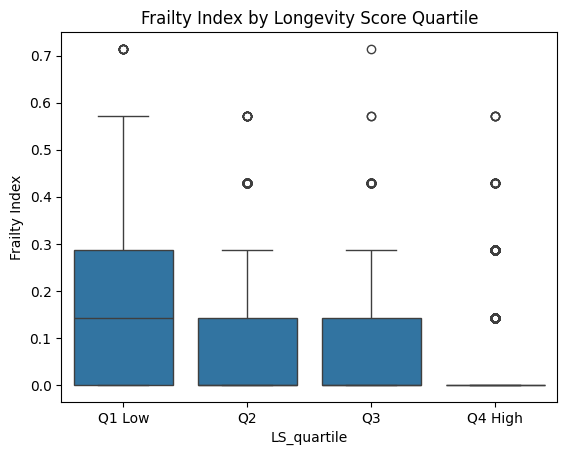

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=val,
    x="LS_quartile",
    y="frailty_index",
    order=["Q1 Low","Q2","Q3","Q4 High"]
)
plt.title("Frailty Index by Longevity Score Quartile")
plt.ylabel("Frailty Index")
plt.show()


In [58]:
val = df_val[["SEQN", "longevity_score", "frailty_index"]].dropna()
val["LS_quartile"] = pd.qcut(val["longevity_score"], 4, labels=["Q1 Low","Q2","Q3","Q4 High"])

# top frail cases in Q4 (best LS)
q4_bad = (
    val[val["LS_quartile"] == "Q4 High"]
    .sort_values("frailty_index", ascending=False)
    .head(10)
)
q4_bad



,SEQN,longevity_score,frailty_index,LS_quartile
2199,85931.0,727.558431,0.571429,Q4 High
9296,93028.0,726.321188,0.571429,Q4 High
9840,93572.0,726.576895,0.571429,Q4 High
9711,93443.0,710.808181,0.571429,Q4 High
7996,91728.0,696.346182,0.428571,Q4 High
3552,87284.0,721.403316,0.428571,Q4 High
8365,92097.0,728.957440,0.428571,Q4 High
163,83895.0,720.970573,0.428571,Q4 High
5,83737.0,703.118052,0.428571,Q4 High
3681,87413.0,691.441996,0.428571,Q4 High


In [59]:
# Rebuild val
val = df_val[["SEQN", "longevity_score", "frailty_index", "age"]].dropna()
val["LS_quartile"] = pd.qcut(val["longevity_score"], 4,
                             labels=["Q1 Low", "Q2", "Q3", "Q4 High"])

print(val.groupby("LS_quartile")["frailty_index"].mean())

# Re-check the "worst" Q4 cases
q4_bad = (
    val[val["LS_quartile"] == "Q4 High"]
    .sort_values("frailty_index", ascending=False)
    .head(10)
)
q4_bad


LS_quartile
Q1 Low     0.148587
Q2         0.083777
Q3         0.055091
Q4 High    0.039081
Name: frailty_index, dtype: float64


/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_52709/664854417.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(val.groupby("LS_quartile")["frailty_index"].mean())


,SEQN,longevity_score,frailty_index,age,LS_quartile
2199,85931.0,727.558431,0.571429,80.0,Q4 High
9296,93028.0,726.321188,0.571429,61.0,Q4 High
9840,93572.0,726.576895,0.571429,80.0,Q4 High
9711,93443.0,710.808181,0.571429,73.0,Q4 High
7996,91728.0,696.346182,0.428571,76.0,Q4 High
3552,87284.0,721.403316,0.428571,80.0,Q4 High
8365,92097.0,728.957440,0.428571,80.0,Q4 High
163,83895.0,720.970573,0.428571,80.0,Q4 High
5,83737.0,703.118052,0.428571,72.0,Q4 High
3681,87413.0,691.441996,0.428571,41.0,Q4 High


In [1]:
# saving
# df_val.to_pickle("df_val.pkl")

# to load
import pandas as pd

df_val = pd.read_pickle("df_val.pkl")


## validation pipeline

Validation N after dropna: 9,971

--- Descriptives ---
       longevity_score  frailty_index          age
count      9971.000000    9971.000000  9971.000000
mean        657.477452       0.081637    31.899408
std          46.031119       0.131951    24.768829
min         300.000000       0.000000     0.000000
25%         629.520835       0.000000     9.000000
50%         656.680415       0.000000    27.000000
75%         687.642042       0.142857    53.000000
max         850.000000       0.714286    80.000000

Frailty group sizes:
frail_group
Non-frail            8325
Frail (FI ≥ 0.25)    1646
Name: count, dtype: int64

Frailty group proportions:
frail_group
Non-frail            0.835
Frail (FI ≥ 0.25)    0.165
Name: proportion, dtype: float64

Frailty by Longevity Score quartile (mean FI):
LS_quartile
Q1 (lowest)     0.149
Q2              0.084
Q3              0.055
Q4 (highest)    0.039
Name: frailty_index, dtype: float64

Pearson correlation (LS vs FI): -0.320

--- Cohen's d (Non-fra

/var/folders/qp/44xx9pgd1_7c2_fs4jl3hf4h0000gn/T/ipykernel_55718/2503155318.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(val.groupby("LS_quartile")["frailty_index"].mean().round(3))


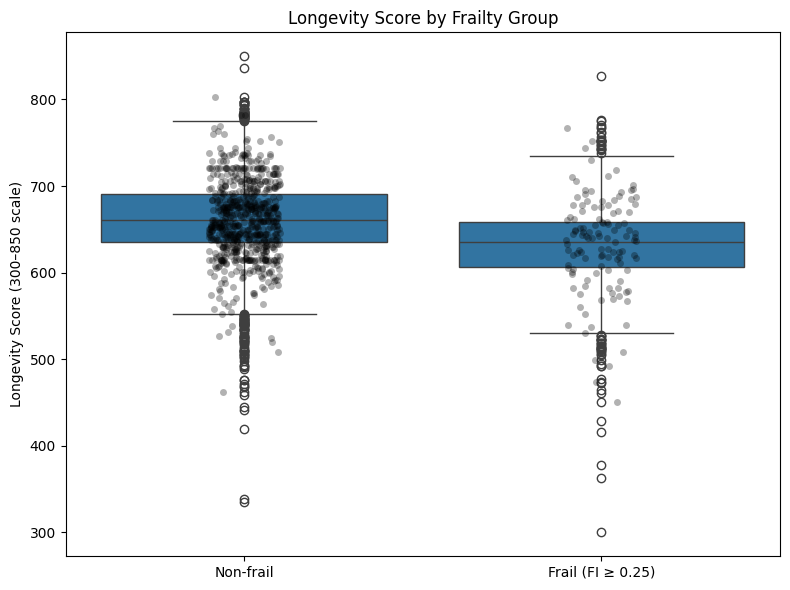

<Figure size 640x480 with 0 Axes>

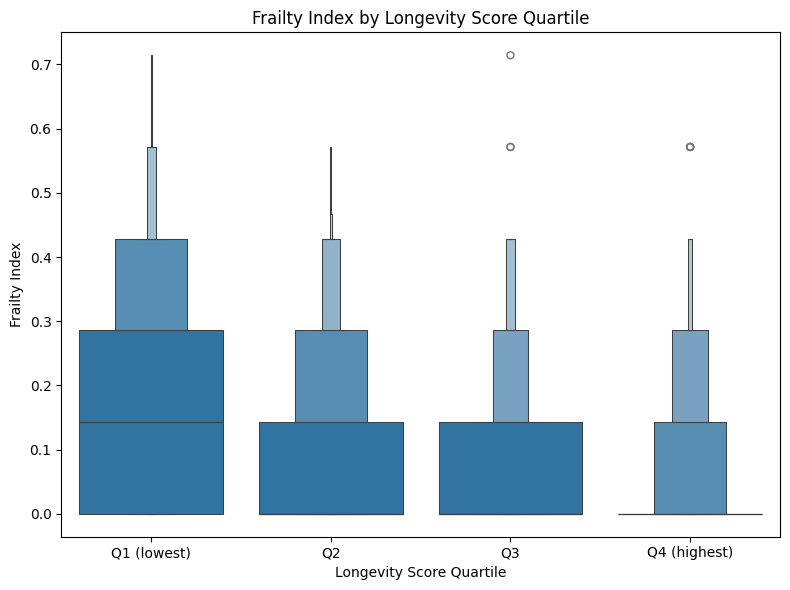

/Users/johnmcdonnell/.pyenv/versions/3.14.0/envs/py314/lib/python3.14/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


<Figure size 640x480 with 0 Axes>

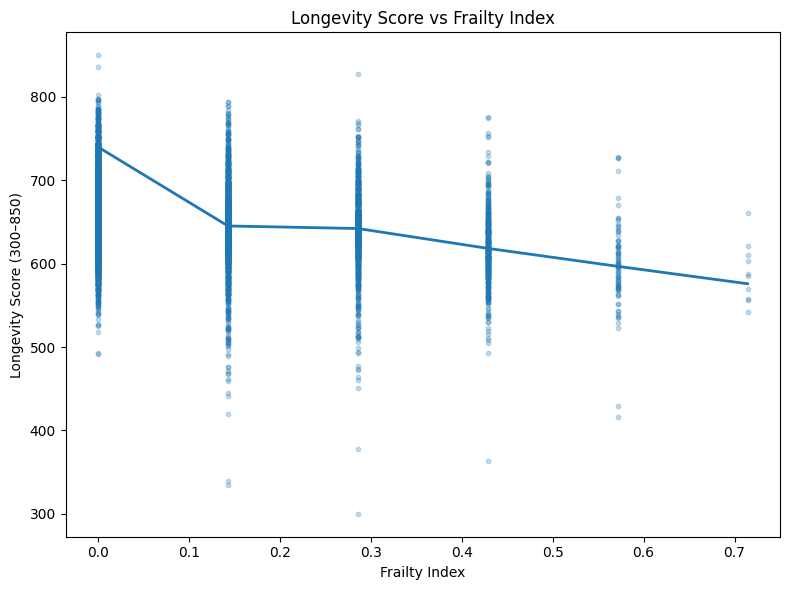

<Figure size 640x480 with 0 Axes>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: LOWESS if statsmodels is installed
try:
    import statsmodels.api as sm
    HAS_SM = True
except ImportError:
    HAS_SM = False
    print("statsmodels not found – LOWESS curve will be skipped.")


def run_longevity_frailty_validation(df_val, frailty_cut=0.25):
    """
    Validation pipeline:
    - Cleans data
    - Builds frailty groups
    - Computes correlation, Cohen's d, eta^2
    - Makes fast, publication-ready plots
    """

    # --------------------------------------------------------
    # 1. Minimal working dataset
    # --------------------------------------------------------
    required = ["SEQN", "longevity_score", "frailty_index", "age"]
    missing = [c for c in required if c not in df_val.columns]
    if missing:
        raise ValueError(f"Required columns missing: {missing}")

    val = df_val[required].dropna().copy()
    print(f"Validation N after dropna: {len(val):,}")

    # --------------------------------------------------------
    # 2. Frailty groups and LS quartiles
    # --------------------------------------------------------
    val["frail_group"] = np.where(
        val["frailty_index"] >= frailty_cut,
        "Frail (FI ≥ {:.2f})".format(frailty_cut),
        "Non-frail"
    )

    # LS quartiles
    val["LS_quartile"] = pd.qcut(
        val["longevity_score"],
        4,
        labels=["Q1 (lowest)", "Q2", "Q3", "Q4 (highest)"]
    )

    # --------------------------------------------------------
    # 3. Descriptive summaries
    # --------------------------------------------------------
    print("\n--- Descriptives ---")
    print(val[["longevity_score", "frailty_index", "age"]].describe())

    print("\nFrailty group sizes:")
    print(val["frail_group"].value_counts(normalize=False))
    print("\nFrailty group proportions:")
    print(val["frail_group"].value_counts(normalize=True).round(3))

    print("\nFrailty by Longevity Score quartile (mean FI):")
    print(val.groupby("LS_quartile")["frailty_index"].mean().round(3))

    # --------------------------------------------------------
    # 4. Correlation: Longevity Score vs Frailty Index
    # --------------------------------------------------------
    r = val["longevity_score"].corr(val["frailty_index"])
    print("\nPearson correlation (LS vs FI): {:.3f}".format(r))

    # --------------------------------------------------------
    # 5. Effect size: Cohen's d (frail vs non-frail)
    # --------------------------------------------------------
    frail = val.loc[val["frail_group"].str.startswith("Frail"), "longevity_score"]
    non_frail = val.loc[val["frail_group"] == "Non-frail", "longevity_score"]

    m_frail = frail.mean()
    m_non  = non_frail.mean()
    s_frail = frail.std()
    s_non   = non_frail.std()

    # pooled SD
    n_frail = len(frail)
    n_non   = len(non_frail)
    s_pooled = np.sqrt(
        ((n_frail - 1) * s_frail**2 + (n_non - 1) * s_non**2) /
        (n_frail + n_non - 2)
    )
    d = (m_non - m_frail) / s_pooled

    print("\n--- Cohen's d (Non-frail vs Frail) ---")
    print(f"Mean LS (Non-frail): {m_non:.2f}")
    print(f"Mean LS (Frail):     {m_frail:.2f}")
    print(f"Cohen's d:           {d:.3f}  (positive = higher LS in non-frail)")

    # --------------------------------------------------------
    # 6. Effect size: η² for LS by frailty group (one-way ANOVA)
    # --------------------------------------------------------
    y = val["longevity_score"].values
    grand_mean = y.mean()

    # Group-wise
    group_means = val.groupby("frail_group")["longevity_score"].mean()
    group_sizes = val["frail_group"].value_counts()

    # Between-group SS
    ss_between = 0.0
    for g in group_means.index:
        ss_between += group_sizes[g] * (group_means[g] - grand_mean) ** 2

    # Total SS
    ss_total = ((y - grand_mean) ** 2).sum()

    eta_sq = ss_between / ss_total

    print("\n--- ANOVA effect size (η²) ---")
    print("η² (frail_group → LS): {:.3f}".format(eta_sq))

    # --------------------------------------------------------
    # 7. Boxplot + sampled jitter (fast alternative to swarm)
    # --------------------------------------------------------
    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=val,
        x="frail_group",
        y="longevity_score"
    )

    # jitter a sample of points
    jitter_sample = val.sample(min(800, len(val)), random_state=42)
    sns.stripplot(
        data=jitter_sample,
        x="frail_group",
        y="longevity_score",
        color="black",
        alpha=0.3
    )

    plt.title("Longevity Score by Frailty Group")
    plt.xlabel("")
    plt.ylabel("Longevity Score (300–850 scale)")
    plt.tight_layout()
    plt.show()
    plt.savefig("fig_ls_frail_groups.png", dpi=300, bbox_inches="tight")
    # --------------------------------------------------------
    # 8. Boxenplot across LS quartiles (FI distribution)
    # --------------------------------------------------------
    plt.figure(figsize=(8,6))
    sns.boxenplot(
        data=val,
        x="LS_quartile",
        y="frailty_index"
    )
    plt.title("Frailty Index by Longevity Score Quartile")
    plt.xlabel("Longevity Score Quartile")
    plt.ylabel("Frailty Index")
    plt.tight_layout()
    plt.show()
    plt.savefig("fig_ls_fi_quartile.png", dpi=300, bbox_inches="tight")
    # --------------------------------------------------------
    # 9. Scatter LS vs FI with optional LOWESS
    # --------------------------------------------------------
    plt.figure(figsize=(8,6))
    plt.scatter(
        val["frailty_index"],
        val["longevity_score"],
        alpha=0.25,
        s=10
    )
    plt.xlabel("Frailty Index")
    plt.ylabel("Longevity Score (300–850)")
    plt.title("Longevity Score vs Frailty Index")

    if HAS_SM:
        # LOWESS smoothing
        lowess = sm.nonparametric.lowess
        smoothed = lowess(
            val["longevity_score"],
            val["frailty_index"],
            frac=0.3
        )
        plt.plot(smoothed[:, 0], smoothed[:, 1], linewidth=2)

    plt.tight_layout()
    plt.show()
    plt.savefig("fig_ls_fi_scatter.png", dpi=300, bbox_inches="tight")
    # --------------------------------------------------------
    # 10. Return the working frame for further analysis
    # --------------------------------------------------------
    return val


# ============================================================
# RUN THE PIPELINE
# ============================================================
val_results = run_longevity_frailty_validation(df_val, frailty_cut=0.25)


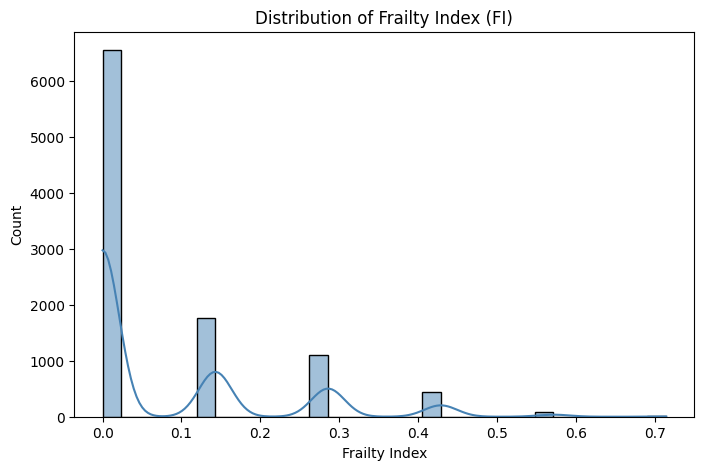

<Figure size 640x480 with 0 Axes>

In [8]:
# assess distribution of frailty index
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_val["frailty_index"].dropna(), 
             bins=30, 
             kde=True, 
             color="steelblue")

plt.title("Distribution of Frailty Index (FI)")
plt.xlabel("Frailty Index")
plt.ylabel("Count")

plt.show()

plt.savefig("fig_fi_hist.png", dpi=300, bbox_inches="tight")

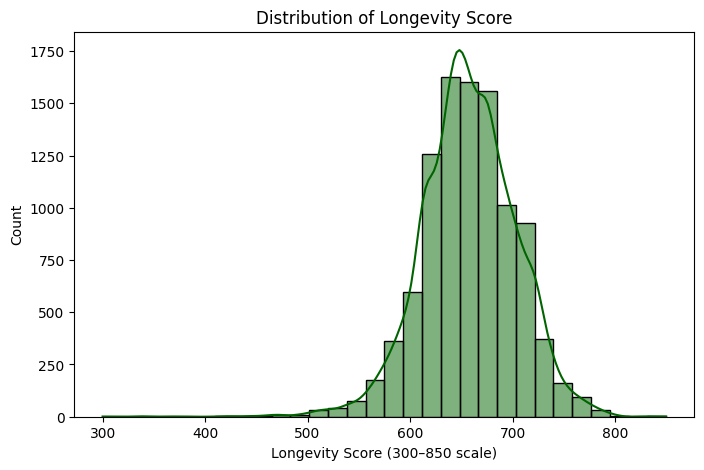

<Figure size 640x480 with 0 Axes>

In [9]:
# assess distribution of longevity score 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_val["longevity_score"].dropna(),
             bins=30,
             kde=True,
             color="darkgreen")

plt.title("Distribution of Longevity Score")
plt.xlabel("Longevity Score (300–850 scale)")
plt.ylabel("Count")

plt.show()

plt.savefig("fig_ls_hist.png", dpi=300, bbox_inches="tight")

In [ ]:
plt.savefig("fig_fi_hist.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_ls_hist.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_ls_fi_scatter.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_ls_fi_quartile.png", dpi=300, bbox_inches="tight")
plt.savefig("fig_ls_frail_groups.png", dpi=300, bbox_inches="tight")


Use these filenames:

fig_fi_hist.png

fig_ls_hist.png

fig_ls_fi_scatter.png

fig_ls_fi_quartile.png

fig_ls_frail_groups.png

Place them in the same directory as the markdown file — Jupyter will pick them up on export.